# Zillow's Home Value Prediction (Zestimate) 
Author: Matthew Huh

## About the Data

The data for this project has been provided by Zillow in a competition hosted by Kaggle. The objective of this competition is to develop the most accurate regressing model, and determine how close we can get to estimating a property's actual value (Zestimate)

In [1]:
# Necessary imports
import os
import random
import time
import timeit
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
%matplotlib inline

# Modelling packages
from sklearn import ensemble, linear_model
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import adjusted_rand_score, classification_report, confusion_matrix, silhouette_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize

# Plotly packages
import cufflinks as cf
import ipywidgets as widgets
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
from scipy import special
py.offline.init_notebook_mode(connected=True)

# Access data folder
os.chdir('C:\\Users\\mhuh22\\Desktop\\datascience\\Datasets\\Zillow')

C:\Users\mhuh22\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# View the contents in this folder
os.listdir()

['.ipynb_checkpoints',
 'properties_2016.csv',
 'properties_2017.csv',
 'sample_submission.csv',
 'train_2016_v2.csv',
 'train_2017.csv',
 'Untitled.ipynb',
 'zillow_data_dictionary.xlsx']

In [3]:
# Import the data
data_2016 = pd.read_csv('properties_2016.csv', engine='python', skiprows=lambda i: i>0 and random.random() > 0.01)

In [4]:
# Preview the data
data_2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,13115547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015.0,NaN,232.18,NaN,NaN,NaN
1,13137147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015.0,NaN,659.34,NaN,NaN,NaN
2,76914547,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,61072.0,176899.0,2014.0,115827.0,NaN,NaN,NaN,NaN
3,17079308,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,1.0,NaN,66416.0,199265.0,2015.0,132849.0,2196.14,NaN,NaN,6.111003e+13
4,17201376,NaN,NaN,NaN,3.0,3.0,NaN,NaN,3.0,66.0,...,2.0,NaN,241694.0,402820.0,2015.0,161126.0,4426.76,NaN,NaN,6.111008e+13


In [5]:
train_2016 = pd.read_csv('train_2016_v2.csv')

train_2016.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [27]:
train_df = pd.concat([data_2016, train_2016], axis=1, join_axes=[data_2016.parcelid])

In [22]:
q1, q3 = np.percentile(train_2016['logerror'],[25,75])
iqr = q3 - q1
lb = q1 - (1.5 * iqr)
ub = q3 + (1.5 * iqr)

C:\Users\mhuh22\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated

C:\Users\mhuh22\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



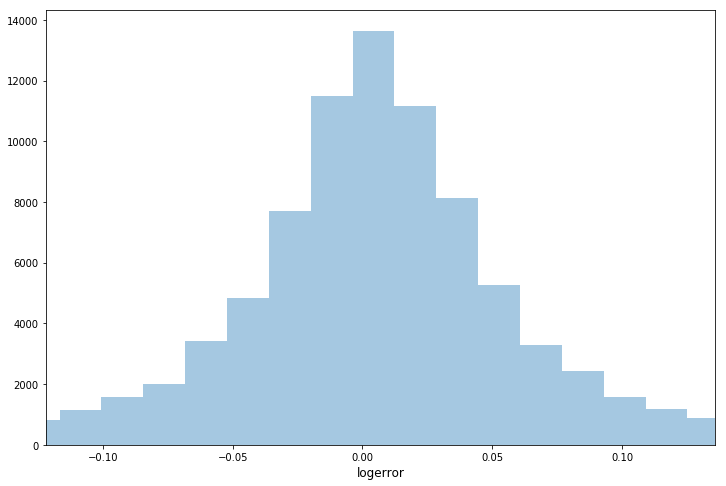

In [26]:
ulimit = np.percentile(train_2016.logerror.values, 99)
llimit = np.percentile(train_2016.logerror.values, 1)
train_2016['logerror'].ix[train_2016['logerror']>ulimit] = ulimit
train_2016['logerror'].ix[train_2016['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
plt.xlim(lb, ub)
sns.distplot(train_2016.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

In [6]:
# View the size of the dataframe
data_2016.shape

(29606, 58)

In [68]:
# View all the features in the dataset, 
# as well as a brief description of each one
dictionary = pd.read_excel('zillow_data_dictionary.xlsx')
dictionary['dtypes'] = data_2016.dtypes.values

dictionary

,Feature,Description,dtypes
0,'airconditioningtypeid',Type of cooling system present in the home (i...,int64
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ...",float64
2,'basementsqft',Finished living area below or partially below...,float64
3,'bathroomcnt',Number of bathrooms in home including fractio...,float64
4,'bedroomcnt',Number of bedrooms in home,float64
5,'buildingqualitytypeid',Overall assessment of condition of the buildi...,float64
6,'buildingclasstypeid',"The building framing type (steel frame, wood f...",float64
7,'calculatedbathnbr',Number of bathrooms in home including fractio...,float64
8,'decktypeid',Type of deck (if any) present on parcel,float64
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + si...,float64


In [70]:
# View number of missing values in each category
data_2016.isna().sum().sort_values(ascending=False)

storytypeid                     29593
basementsqft                    29592
yardbuildingsqft26              29573
fireplaceflag                   29565
architecturalstyletypeid        29541
typeconstructiontypeid          29538
finishedsquarefeet13            29529
buildingclasstypeid             29466
decktypeid                      29440
finishedsquarefeet6             29410
poolsizesum                     29313
pooltypeid2                     29295
pooltypeid10                    29253
taxdelinquencyyear              29048
taxdelinquencyflag              29048
hashottuborspa                  28942
yardbuildingsqft17              28798
finishedsquarefeet15            27711
finishedsquarefeet50            27541
finishedfloor1squarefeet        27541
fireplacecnt                    26538
threequarterbathnbr             26533
pooltypeid7                     24712
poolcnt                         24401
numberofstories                 22894
airconditioningtypeid           21541
garagetotals

In [30]:
# # Should be able to display map of all values in the dataframe

# scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
#     [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]

# data = [ dict(
#         type = 'scattergeo',
#         locationmode = 'USA-states',
#         lon = data_2016['longitude'],
#         lat = data_2016['latitude'],
#         text = data_2016['regionidcounty'],
#         mode = 'markers',
#         marker = dict(
#             size = 8,
#             opacity = 0.8,
#             reversescale = True,
#             autocolorscale = False,
#             symbol = 'square',
#             line = dict(
#                 width=1,
#                 color='rgba(102, 102, 102)'
#             ),
#             colorscale = scl,
#             cmin = 0,
# #             color = data_2016['cnt'],
# #             cmax = data_2016['cnt'].max(),
#             colorbar=dict(
#                 title="Number of units"
#             )
#         ))]

# layout = dict(
#         title = 'Location Map',
#         colorbar = True,
#         geo = dict(
#             scope='usa',
#             projection=dict( type='albers usa' ),
#             showland = True,
#             landcolor = "rgb(250, 250, 250)",
#             subunitcolor = "rgb(217, 217, 217)",
#             countrycolor = "rgb(217, 217, 217)",
#             countrywidth = 0.5,
#             subunitwidth = 0.5
#         ),
#     )

# fig = dict( data=data, layout=layout )
# py.offline.iplot( fig, validate=False, filename='d3-airports' )